In [15]:
from tensorflow import keras 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding , Flatten , Dense  ,LSTM ,Bidirectional
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import re 


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded =drive.CreateFile({'id':'1Qz28uQckU-kr21Ca4dOKJ6azhUHqCkvv'})
downloaded.GetContentFile('scrapping.txt')

In [5]:
with open ('scrapping.txt') as f:
  lines = f.readlines()

In [30]:
data = [line.lower().strip() for line in lines ]

In [31]:
data = [line for line in data if len(line) >=3]

In [32]:
data

['au nom d’allah le tout-miséricordieux, le très-miséricordieux',
 'mon dieu ! accorde ta bénédiction à notre seigneur mohammed (ﷺ) qui a ouvert ce qui était clos, qui a clos ce qui a précédé, le défenseur de la vérité par la vérité, le guide du droit chemin, ainsi qu’à sa famille suivant sa valeur et l’estimation de son ultime dignité.',
 "cheikh seydi el hadj malick sy (rta): l'affranchi",
 'il est cet être capable de dépasser le plan des écorces,',
 'dans une volonté singulière,',
 'ni la décadence du monde environnant,',
 "ni l'appartenance à tel peuple ou tel milieu,",
 'ne constituent des obstacles absolus,',
 "il s'est affranchi de tout,",
 'il est un singulier libre,',
 "la ferveur qui l'étreint quand il se remémore son bien aimé (paix et salut d'allah sur lui) ,",
 'renverse dans leur fondement tous les délices du monde,',
 "il ne s'acquitte pas, même pendant des siècles,",
 'de la dette contractée pour un souffle de son amour,',
 'il lui fait don de son esprit,',
 "son rayonn

In [36]:
corpus = ""
for i in data:
  corpus += i+"\n"

corpus = corpus.lower().split("\n")
tokenizer =Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
total_word = len(word_index) +1

sequences  = tokenizer.texts_to_sequences (corpus)


In [37]:
input_sentences =[]

for line in corpus :
    list_token= tokenizer.texts_to_sequences([line])[0]
    for i in range (1 , len(list_token)):
        n_gram_sentences = list_token[:i+1]
        input_sentences.append(n_gram_sentences)
        
max_len_sentences = max([len(x) for x in  input_sentences])
input_sentences = np.array(pad_sequences(input_sentences , maxlen=max_len_sentences , padding='pre'))

In [38]:
xs , labels = input_sentences[:,:-1] , input_sentences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_word)

In [40]:
model= Sequential([
    Embedding(total_word , 64 , input_length=max_len_sentences -1),
    Bidirectional(LSTM(20)),
    Dense(total_word/2 , activation='relu' , kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.02),
    Dense(total_word , activation ='sigmoid')
    
])

model.summary()

model.compile (loss='categorical_crossentropy' , optimizer = 'adam' , metrics =['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 64)            13568     
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                13600     
_________________________________________________________________
dense (Dense)                (None, 106)               4346      
_________________________________________________________________
dropout (Dropout)            (None, 106)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 212)               22684     
Total params: 54,198
Trainable params: 54,198
Non-trainable params: 0
_________________________________________________________________


In [47]:
history = model.fit(xs , ys ,epochs =100 , verbose =1 )

Epoch 1/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1164 - accuracy: 0.9640
Epoch 2/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1187 - accuracy: 0.9638
Epoch 3/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1146 - accuracy: 0.9639
Epoch 4/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1162 - accuracy: 0.9643
Epoch 5/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1177 - accuracy: 0.9633
Epoch 6/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1148 - accuracy: 0.9638
Epoch 7/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1115 - accuracy: 0.9641
Epoch 8/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1121 - accuracy: 0.9636
Epoch 9/100
1231/1231 [==============================] - 10s 8ms/step - loss: 0.1211 - accuracy: 0.9631
Epoch 10/100
1231/1231 [==============================] - 10s 8m

In [48]:
model.save("my_model.h5")

In [49]:
def graph_plot (history , string):
    plt.plot(history.history[string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

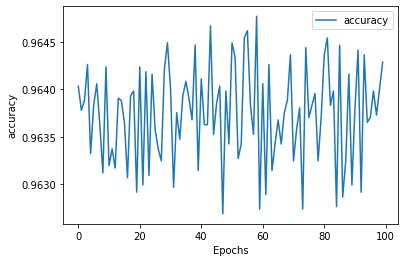

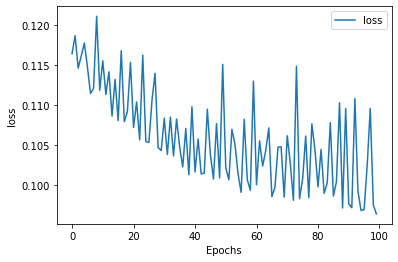

In [50]:
graph_plot(history , 'accuracy')
graph_plot(history , 'loss')

In [51]:
seed_text = "Maodo"
next_word =100

for _ in range (next_word):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list] , maxlen=max_len_sentences -1 , padding='pre')
    predicted = model.predict_classes(token_list , verbose=0)
    output_word = ""
    for word , index in tokenizer.word_index.items():
        if index == predicted :
            output_word = word
            break 
    seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Maodo constituent des obstacles absolus sa جميل isolées le singulier libre en brillant le d'allah sur milieu travers la est le et libre lui de la de qui son droit chemin ainsi qu’à sa famille suivant sa valeur et l’estimation de son ultime dignité sa valeur sa l’estimation de vos dignité de son ultime dignité est dignité le l’estimation de son ultime dignité est dignité sa valeur et l’estimation de son ultime dignité est dignité sa valeur et l’estimation de son ultime dignité sa et est sa libre est sa libre est est sa libre lui le sa libre le sa


In [ ]:
set_text = list(seed_text)